# Define morphological models with `neat.PhysTree`
The Class `neat.PhysTree` is used to define the physiological parameters of neuron models. It inherits from `neat.MorphTree` and thus has all its functionality. Just as `neat.MorphTree`, instances are initialized based on the standard `.swc` format:

In [1]:
from neat import PhysTree
ph_tree = PhysTree(file_n='morph/L23PyrBranco.swc')

## Defining physiological parameters

A `PhysTree` consists of `neat.PhysNode` instances, which inherit from `neat.MorphNode`. Compared to a `MorphNode`, a `PhysNode` has extra attributes (initialized to some default value) defining physiological parameters:

In [2]:
# specific membrance capacitance (uF/cm^2)
print('default c_m node 1:', ph_tree[1].c_m)
# axial resisitance (MOhm*cm)
print('default r_a node 1:', ph_tree[1].r_a)
# point-like shunt located at {'node': node.index, 'x': 1.} (uS)
print('default g_shunt node 1:', ph_tree[1].g_shunt)
# leak and ion channel currents, stored in a dict with
# key: 'channel_name', value: [g_max, e_rev]
print('default currents node 1:', ph_tree[1].currents)

default c_m node 1: 1.0
default r_a node 1: 0.0001
default g_shunt node 1: 0.0
default currents node 1: {}


It is not recommended, and for ion channels even forbidden, to set the parameters directly via the nodes. Rather, the parameters should be specified with associated functions of `PhysTree`. These functions accept a `node_arg` keyword argument, which allows selecting a specific set of nodes. Parameters, can be given as `float`, in which case all nodes in `node_arg` will be set to the same value, a `dict` of `{node.index: parameter_value}`, or a callable function where the input is the distance of the middle of the node (`loc = {'node': node.index, 'x': .5}`) to the soma and the output the parameter.

Let's use `PhysTree.setPhysiology()` to set capacitance (1st argument) and axial resistance (2nd argument) in the whole tree:

In [3]:
ph_tree.setPhysiology(lambda x: .8 if x < 60. else 1.6*.8, 100.*1e-6)

Here, we defined the capacitance to be $.8$ $\mu$F/cm$^2$ when the mid-point of the node is less than 60 $\mu$m from the soma and $1.6*.8$ $\mu$F/cm$^2$, a common factor to take dendritic spines into account. Axial resistance was set to a constant value throughout the tree.

To set ion channels (see the 'Ionchannels in NEAT' tutorial on how to create your own ion channels), we must create the ion channel instance first. Here, we'll set a default sodium and potassium channel:

In [4]:
from neat.channels.channelcollection.channelcollection import Na_Ta, Kv3_1
# create the ion channel instances
na_chan = Na_Ta()
k_chan = Kv3_1()
# set the sodium channel only at the soma, with a reversal of 50 mV
ph_tree.addCurrent(na_chan, 1.71*1e6, 50., node_arg=[ph_tree[1]])
# set the potassium channel throughout the dendritic tree, at 1/10th 
# of its somatic conductance, and with a reversal of -85 mV
gk_soma = 0.45*1e6
ph_tree.addCurrent(k_chan, lambda x: gk_soma if x < .1 else gk_soma/10., -85.)

Now, we only have to set the leak current. We have two possibilities for this: (i) we could set the leak current by providing conductance and reversal in the standard way with `PhysTree.setLeakCurrent()` or (ii) with could fit the leak current to fix equilibrium potential and membrane time scale (if possible) with `PhysTree.fitLeakCurrent()`. We take the second option here:

In [5]:
# fit leak current to yield an equilibrium potential of -70 mV and
# a total membrane time-scale of 10 ms (with channel opening 
# probabilities evaluated at -70 mV)
ph_tree.fitLeakCurrent(-70., 10.)

## Inspecting the physiological parameters

We can now inspect the contents of various `PhysNode` instances:

In [6]:
# soma node
print(ph_tree[1])

SNode 1 --- (r_a = 9.999999999999999e-05 MOhm*cm, g_Na_Ta = 1710000.0 uS/cm^2, g_Kv3_1 = 450000.0 uS/cm^2, g_L = 31.54081073184777 uS/cm^2, c_m = 0.8 uF/cm^2)


In [7]:
# dendrite node
print(ph_tree[115])

SNode 115, Parent: SNode 114 --- (r_a = 9.999999999999999e-05 MOhm*cm, g_Kv3_1 = 45000.0 uS/cm^2, g_L = 123.19344287327351 uS/cm^2, c_m = 1.2800000000000002 uF/cm^2)


Or, to get the full information on conductances and reversal potentials of membrane currents:

In [8]:
# soma node
print(ph_tree[1].currents)

{'Na_Ta': [1710000.0, 50.0], 'Kv3_1': [450000.0, -85.0], 'L': [31.54081073184777, -48.638804987272536]}


In [9]:
# dendrite node
print(ph_tree[115].currents)

{'Kv3_1': [45000.0, -85.0], 'L': [123.19344287327351, -69.41475491536458]}


## Active dendrites compared to closest passive version

Imagine we aim to investigate the role of active dendritic channels, and to that purpose want to compare the active dendritic tree with a passive version. We may compute the leak conductance of this "passified" tree as the sum of all ion channel conductance evaluate at the equilibrium potential. The equilibrium potentials is stored on the tree using `PhysTree.setEEq()`:

In [10]:
ph_tree.setEEq(-70.)

To obtain the passified tree, we use `PhysTree.asPassiveMembrane()`. However, this function will overwrite the parameters of the original nodes, if we want to maintain the initial tree, we have to copy it first:

In [11]:
# copy the initial tree
ph_tree_pas = ph_tree.__copy__()
# set to passive (except the soma)
ph_tree_pas.asPassiveMembrane([n for n in ph_tree_pas if n.index != 1])

We can now inspect the nodes:

In [12]:
# soma node
print(ph_tree_pas[1])

SNode 1 --- (r_a = 9.999999999999999e-05 MOhm*cm, g_Na_Ta = 1710000.0 uS/cm^2, g_Kv3_1 = 450000.0 uS/cm^2, g_L = 31.54081073184777 uS/cm^2, c_m = 0.8 uF/cm^2)


In [13]:
# dendrite node
print(ph_tree_pas[115])

SNode 115, Parent: SNode 114 --- (r_a = 9.999999999999999e-05 MOhm*cm, g_L = 128.0 uS/cm^2, c_m = 1.2800000000000002 uF/cm^2)


And the currents:

In [14]:
# soma node
print(ph_tree_pas[1].currents)

{'Na_Ta': [1710000.0, 50.0], 'Kv3_1': [450000.0, -85.0], 'L': [31.54081073184777, -48.638804987272536]}


In [15]:
# dendrite node
print(ph_tree_pas[115].currents)

{'L': [128.0, -70.0]}


Comparing this to the previously shown nodes of the full tree, we see that the dendrite nodes have been "passified".

## Computational tree

The computational tree in `PhysTree` works the same as in `MorphTree`, except that it's derivation also considers changes in physiological parameters, next to changes in morphological parameters.

In [16]:
ph_tree.setCompTree()
# compare number of nodes in computational tree and original tree
ph_tree.treetype = 'original'
print('%d nodes in original tree'%(len(ph_tree)))
ph_tree.treetype = 'computational'
print('%d nodes in computational tree'%(len(ph_tree)))

432 nodes in original tree
98 nodes in computational tree


Compare this to the number of nodes in the computational tree induced solely by the morphological parameters:

In [17]:
from neat import MorphTree
m_tree = MorphTree('morph/L23PyrBranco.swc')
m_tree.setCompTree()
m_tree.treetype = 'computational'
print('%d nodes in computational `MorphTree`'%len(m_tree))

87 nodes in computational `MorphTree`


Note: only call this `PhysTree.setCompTree` when all physiological parameters have been set, and ***never*** change parameters stored at individual nodes when `treetype` is ``computational``, as this leads to the computational tree being inconsistent with the original tree.

# Simulate models with `neat.NeuronSimTree`

NEAT implements an interface to the NEURON simulator, so that models defined by neat-trees can be simulated with the NEURON simulator. To have access to this functionality, the NEURON simulator and it's Python interface need to be installed.

The class `neat.NeuronSimTree` implements this interface, and inherits from `neat.PhysTree`. Hence, a `NeuronSimTree` can be defined in the same way as a `PhysTree`.

In [18]:
from neat import NeuronSimTree
sim_tree = NeuronSimTree(file_n='morph/L23PyrBranco.swc')
sim_tree.setPhysiology(lambda x: .8 if x < 60. else 1.6*.8, 100.*1e-6)
# ... etc

## The `__copy__` function

If a different type of tree is needed than the one originality defined, a handy feature of NEAT's copy function can be used: we can specify the type of tree we want as a keyword argument to `neat.MorphTree.__copy__()`. This function then copies all attributes that both tree classes have in common. Since `NeuronSimTree` is a subclass of `PhysTree`, we end up with an identical tree, but with additional functions and associated attributes to simulate the associated NEURON model.

In [19]:
sim_tree = ph_tree.__copy__(new_tree=NeuronSimTree())

## Setting up a simulation

First, we must initialize the tree structure into hoc.

In [20]:
sim_tree.initModel(t_calibrate=100.)

We may then add inputs to the tree. NEAT implements a number of standard synapse types and current injections. Let's apply a DC current step to the soma and also give some input to a conductance-based dendritic synapse.

In [21]:
# somatic DC current step with amplitude = 0.100 nA, delay = 5. ms and duration = 50. ms
sim_tree.addIClamp((1.,.5), 0.010, 5., 50.)
# dendritic synapse with rise resp. decay times of .2 resp 3. ms and reversal of 0 mV
sim_tree.addDoubleExpSynapse((115,.8), .2, 3., 0.)
# give the dendritic synapse a weight of 0.005 uS and connect it to an input spike train
sim_tree.setSpikeTrain(0, 0.005, [20.,22.,28.,29.,30.])

We will record voltage at the somatic and dendritic site. Recording locations should be stored under the name 'rec locs'.

In [22]:
sim_tree.storeLocs([(1,.5), (115,.8)], name='rec locs')

We can then run the model for $60$ ms and plot the results:

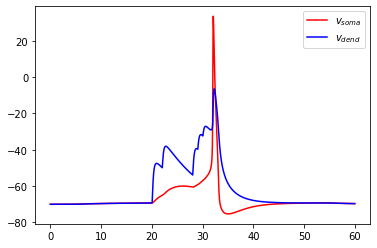

In [23]:
# simulate the model and delete all hoc-variables afterwards
res = sim_tree.run(60.)
sim_tree.deleteModel()

# plot the results
import matplotlib.pyplot as pl
pl.plot(res['t'], res['v_m'][0], c='r', label=r'$v_{soma}$')
pl.plot(res['t'], res['v_m'][1], c='b', label=r'$v_{dend}$')
pl.legend(loc=0)
pl.show()

## User defined point-process

Note that it is very easy to add user defined point-process to the `NeuronSimTree`. In fact, all any of the default functions to add point-process do, is defining a `neat.MorphLoc` based on the input, so that the point process is added at the right coordinates no matter whether `treetype` was 'original' or 'computational'. All hoc sections are stored in the dict `self.sections` which has as keys the node indices. Hence, in pseudo code one would do:

```
loc = neat.MorphLoc((node.index, x-coordinate), sim_tree)

# define the point process at the correct location
pp = h.user_defined_point_process(sim_tree.sections[loc['node']](loc['x']))

# set its parameters
pp.param1 = val1
pp.param2 = val2
...

# store the point process (e.g. if it is a synapse in `sim_tree.syns`)
sim_tree.syns.append(pp)
```

# Evaluate impedance matrices with `neat.GreensTree`

The class `neat.GreensTree` inherits from `neat.PhysTree` and implements Koch's algorithm [-@Koch1984] to calculate impedances in the Fourrier domain. For a given input current of frequency $\omega$ at location $x$, the impedance gives the linearized voltage response at a location $x^{\prime}$:
\begin{align}
v_{x^{\prime}}(\omega) = z_{x^{\prime}x}(\omega) \, i_x(\omega).
\end{align}
Applying the inverse Fourrier transform yields a convolution in the the time domain:
\begin{align}
v_{x^{\prime}}(t) = z_{x^{\prime}x}(t) \ast i_x(t),
\end{align}
with we call $z_{x^{\prime}x}(t) = FT^{-1} \left(  z_{x^{\prime}x}(\omega) \right)$ the impedance kernel. The steady state impedance is then:
\begin{align}
z_{x^{\prime}x} = \int_0^{\infty} \mathrm{d}t \, z_{x^{\prime}x}(t) = z_{x^{\prime}x}(\omega = 0).
\end{align}

## Computing an impedance kernel

To compute an impedance kernel, we first have to initialize the `GreensTree`:

In [24]:
from neat import GreensTree
greens_tree = ph_tree.__copy__(new_tree=GreensTree())

For the calculation to proceed efficiently, `GreensTree` first sets effective, frequency-dependent boundary conditions for each cylindrical section. Hence we must specify the frequencies at which we want to evaluate impedances. If we aim to also compute temporal kernels, `neat.FourrierTools` is a handy tool to obtain the correct frequencies. Suppose for instance that we aim to compute an impedance kernels from $0$ to $50$ ms:

In [25]:
from neat import FourrierTools
import numpy as np
# create a Fourriertools instance with the temporal array on which to evaluate the impedance kernel
t_arr = np.linspace(0.,50.,1000)
ft = FourrierTools(t_arr)
# appropriate frequencies are stored in `ft.s`
# set the boundary condition for cylindrical segments in `greens_tree`
greens_tree.setImpedance(ft.s)

We can now compute for instance the impedance kernel between dendritic and somatic site:

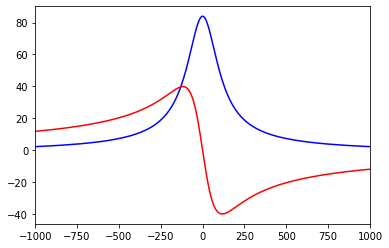

In [26]:
z_trans = greens_tree.calcZF((1,.5), (115,.8))

# plot the kernel
pl.plot(ft.s.imag, z_trans.real, 'b')
pl.plot(ft.s.imag, z_trans.imag, 'r')
pl.xlim((-1000.,1000.))
pl.show()

We can also obtain this kernel in the time domain with the `FourrierTools` object:

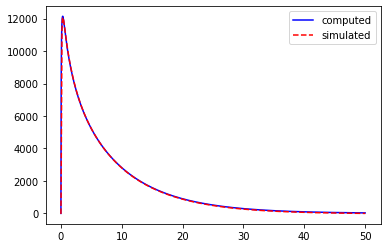

In [27]:
# time domain kernel
tt, zt = ft.ftInv(z_trans)

# comparison with NEURON simulation
sim_tree.initModel(t_calibrate=300.)
i_amp, i_dur = 0.001, 0.1
sim_tree.addIClamp((115,.8), i_amp, 0., i_dur)
res = sim_tree.run(50.)
sim_tree.deleteModel()
res['v_m'] -= res['v_m'][:,-1]
res['v_m'] /= (i_amp*1e-3*i_dur)

# plot the kernel
pl.plot(tt, zt.real, 'b', label='computed')
pl.plot(res['t'], res['v_m'][0], 'r--', label='simulated')
pl.legend(loc=0)
pl.show()

## Computing the impedance matrix

While `GreensTree.calcZF()` could be used to explicitely compute the impedance matrix, `GreensTree.calcImpedanceMatrix()` uses the symmetry and transitivity properties of impedance kernels to further optimize the calculation.

In [28]:
z_locs = [(1,.5), (115,.8)]
z_mat = greens_tree.calcImpedanceMatrix(z_locs)

This matrix has shape ``(len(ft.s), len(z_locs), len(z_locs))``. The zero-frequency component is at `ft.ind_0s`. Hence, the following gives the steady state impedance matrix:

In [29]:
print(z_mat[ft.ind_0s])

[[ 88.07091747+0.j  83.93186356+0.j]
 [ 83.93186356+0.j 183.59769195+0.j]]


# Simplify a model with `neat.CompartmentFitter`

The class `neat.CompartmentFitter` is used to obtain simplified compartmental models, where the parameters of the compartments are optimized to reproduce voltages at any set of locations on the morphology. It is initialized based on a `neat.PhysTree`:

In [30]:
from neat import CompartmentFitter
c_fit = CompartmentFitter(ph_tree)

The function `CompartmentFitter.fitModel()` then returns a `neat.CompartmentTree` object defining the simplified model, with the parameters of the optimized compartments:

In [62]:
# compute a simplified tree containing a somatic and dendritic compartment
f_locs = [(1,.5), (115,.8)]
c_tree = c_fit.fitModel(f_locs, use_all_chans_for_passive=False)

## The simplified model `neat.CompartmentTree`

Each `neat.CompartmentNode` in the `CompartmentTree` stores the optimized parameters of the compartment, and the coupling conductance with it's parent node.

In [63]:
print(c_tree)

>>> Tree
    SNode 0 --- (g_c = 0.000000000000 uS, g_L = 0.009188301476 uS, g_Na_Ta = 14.378466892343 uS, g_Kv3_1 = 7.000477231569 uS, c = 0.000099142300 uF)
    SNode 1, Parent: SNode 0 --- (g_c = 0.009224434868 uS, g_L = 0.000411034483 uS, g_Na_Ta = 0.000000000002 uS, g_Kv3_1 = 0.072296414995 uS, c = 0.000004268327 uF)


To keep track of the mapping between compartments and locations, each `CompartmentNode` also has a `loc_ind` attribute, containing the index of the location in the original list given to `CompartmentFitter.fitModel()` (here `f_locs`) to which the compartment is fitted:

In [64]:
# node 0 corresponds to location 0 in `f_locs`
print('node index: %d, loc index: %d'%(c_tree[0].index, c_tree[0].loc_ind))
# node 1 corresponds to location 1 in `f_locs`
print('node index: %d, loc index: %d'%(c_tree[1].index, c_tree[1].loc_ind))

node index: 0, loc index: 0
node index: 1, loc index: 1


Here, these indices correspond, but in general there is ***no*** guarantee this will be the case. A list of 'fake' locations for the compartmental model can also be obtained. These locations contain nothing but the node index and an x-coordinate without meaning.

In [65]:
c_locs = c_tree.getEquivalentLocs()
print(c_locs[0], c_locs[1])

(0, 0.5) (1, 0.5)


## Simulate the simplified model with `neat.NeuronCompartmentTree`

The simplified model can be simulated directly in NEURON, with the same API as `neat.NeuronSimTree`. To do so, the function `neat.createReducedNeuronModel()` converts the `CompartmentTree` to a `neat.NeuronCompartmentTree`:

In [67]:
from neat import createReducedNeuronModel
c_sim_tree = createReducedNeuronModel(c_tree)

We may now check whether our simplification was successful by running the same simulation for the full and reduced models:

In [68]:
# initialize, run and delete the full model, set input locations as stored in `f_locs`
sim_tree.initModel(t_calibrate=100.)
sim_tree.addIClamp(f_locs[0], .01, 5., 50.)
sim_tree.addDoubleExpSynapse(f_locs[1], .2, 3., 0.)
sim_tree.setSpikeTrain(0, 0.002, [20.,22.,28.,28.5,29.,30.,31.])
sim_tree.storeLocs(f_locs, name='rec locs')
res_full = sim_tree.run(60.)
sim_tree.deleteModel()

# initialize and run the simplified model, set input locations as stored in `c_locs`
c_sim_tree.initModel(t_calibrate=100.)
c_sim_tree.addIClamp(c_locs[0], 0.01, 5., 50.)
c_sim_tree.addDoubleExpSynapse(c_locs[1], .2, 3., 0.)
c_sim_tree.setSpikeTrain(0, 0.002, [20.,22.,28.,28.5,29.,30.,31.])
c_sim_tree.storeLocs(c_locs, name='rec locs')
res_reduced = c_sim_tree.run(60.)
# print the hoc topology of the reduced model
from neuron import h
h.topology()
# delete the reduced model
c_sim_tree.deleteModel()


|-|       0(0-1)
  `|       1(0-1)



We compare somatic and dendritic voltages in both models:

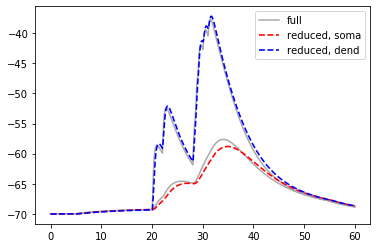

In [69]:
pl.plot(res_full['t'], res_full['v_m'][0], c='DarkGrey', label='full')
pl.plot(res_full['t'], res_full['v_m'][1], c='DarkGrey')
pl.plot(res_reduced['t'], res_reduced['v_m'][0], 'r--', lw=1.6, label='reduced, soma')
pl.plot(res_reduced['t'], res_reduced['v_m'][1], 'b--', lw=1.6, label='reduced, dend')
pl.legend(loc=0)
pl.show()